In [1]:
# Creating Context
from pyspark import SparkContext
sc = SparkContext(appName= 'lab03')

In [2]:
# Creating Session
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.getOrCreate()
#spark = SQLContext(sc)

In [3]:
# Importing Data
############ tempreture_readings ############
from pyspark.sql.types import StructField,IntegerType, DateType,StringType,StructType,FloatType
newDF_temp =[StructField('StationNO',IntegerType(),True),
       StructField('date',DateType(),True),
       StructField('time',StringType(),True),
       StructField('temp',FloatType(),True),
       StructField('quality',StringType(),True)
       ]
finalStruct_temp =StructType(fields=newDF_temp)
tempreture_readings = spark.read.csv("short_temp.csv",header=False,sep = ';' ,schema = finalStruct_temp)


############ precipitation_readings ############
newDF_per =[StructField('StationNO',IntegerType(),True),
       StructField('date',DateType(),True),
       StructField('time',StringType(),True),
       StructField('precipitation',FloatType(),True),
       StructField('quality',StringType(),True)
       ]
finalStruct_per =StructType(fields=newDF_per)
precipitation_readings = spark.read.csv("precipitation-readings.csv",header=False,sep = ';' ,schema = finalStruct_per)


############ stations_ostergotland ############
newDF_station =[StructField('StationNO',IntegerType(),True),
       StructField('StationName',StringType(),True),
       StructField('height',FloatType(),True),
       StructField('lat',FloatType(),True),
       StructField('long',FloatType(),True),
       StructField('fromDate',DateType(),True),
       StructField('toDate',DateType(),True),
       StructField('elevation',StringType(),True)
       ]
finalStruct_station =StructType(fields=newDF_station)
stations_ostergotland = spark.read.csv("stations-Ostergotland.csv",header=False,sep = ';', schema = finalStruct_station)

In [4]:
# Creating Year, Month and Day columns
from pyspark.sql.functions import year, month, dayofmonth

tempreture_readings = tempreture_readings.withColumn('Year', year('date'))
tempreture_readings = tempreture_readings.withColumn('Month', month('date'))
tempreture_readings = tempreture_readings.withColumn('day', dayofmonth('date'))


precipitation_readings = precipitation_readings.withColumn('Year', year('date'))
precipitation_readings = precipitation_readings.withColumn('Month', month('date'))
precipitation_readings = precipitation_readings.withColumn('day', dayofmonth('date'))

Question 1

In [5]:
############ Max temp in each year ordered by max(temp) ############
Year_maxTemp = tempreture_readings.select('Year','temp').filter(
     # Filter based on the year
    (tempreture_readings.Year>= 1950) & (tempreture_readings.Year <= 2014)).groupBy(
     # Group by station and Year
     'Year').max(
     # Max of temp
    'temp').orderBy('max(temp)',ascending = False)


############ Min temp in each year ordered by min(temp) ############
Year_minTemp = tempreture_readings.select('Year','temp').filter(
     # Filter based on the year
    (tempreture_readings.Year>= 1950) & (tempreture_readings.Year <= 2014)).groupBy(
     # Group by station and Year
    'Year').min(
     # Min of temp
    'temp').orderBy('min(temp)',ascending = False)


Question 1 part a

In [6]:
############ Stations with Max temp in each year ordered by max(temp) ############
Year_maxTemp = tempreture_readings.select('Year','temp').filter(
     # Filter based on the year
    (tempreture_readings.Year>= 1950) & (tempreture_readings.Year <= 2014)).groupBy(
     # Group by station and Year
     'Year').max(
     # Max of temp
    'temp').orderBy('max(temp)',ascending = False)

# Changing the column name
Year_maxTemp = Year_maxTemp.withColumnRenamed('max(temp)','temp')

# Station - Year - Temp dataframe
station_year_temp = tempreture_readings.select('stationNO','Year','temp').filter(
    (tempreture_readings.Year>= 1950) & (tempreture_readings.Year <= 2014))

# Joining Year_maxTemp and station_year_temp to add the Station to the Year_maxTemp
Station_Year_maxTemp = Year_maxTemp.join(station_year_temp, ['Year','temp'],'left').orderBy(
    'temp',ascending = False).distinct()


############ Stations with Min temp in each year ordered by min(temp) ############
Year_minTemp = tempreture_readings.select('Year','temp').filter(
     # Filter based on the year
    (tempreture_readings.Year>= 1950) & (tempreture_readings.Year <= 2014)).groupBy(
     # Group by station and Year
     'Year').min(
     # Max of temp
    'temp').orderBy('min(temp)',ascending = False)

# Changing the column name
Year_minTemp = Year_minTemp.withColumnRenamed('min(temp)','temp')

# Station - Year - Temp dataframe
station_year_temp = tempreture_readings.select('stationNO','Year','temp').filter(
    (tempreture_readings.Year>= 1950) & (tempreture_readings.Year <= 2014))

# Joining Year_maxTemp and station_year_temp to add the Station to the Year_maxTemp
Station_Year_minTemp = Year_minTemp.join(station_year_temp, ['Year','temp'],'left').orderBy(
    'temp',ascending = False).distinct()


Question 2 with API

In [7]:
Y_M_temp = tempreture_readings.select('Year','Month','stationNO','temp')
Y_M_temp = Y_M_temp.filter((Y_M_temp.Year >= 1950) & (Y_M_temp.Year <= 2014) & (Y_M_temp.temp > 10))

# Number of records in each month of each year
Y_M_count = Y_M_temp.groupBy('Year','Month').count().orderBy('count',ascending = False)

# Number of distinct records in each month of each year
Y_M_count_distinct = Y_M_temp.distinct().groupBy('Year','Month').count().orderBy('count',ascending = False)

Question 2 with SQL query

In [8]:
# Adding table to the Session
tempreture_readings.createOrReplaceTempView('tempreture_readings')

# Number of records in each month of each year
Query = 'SELECT Year, Month, COUNT(*) AS Count FROM tempreture_readings WHERE (temp > 10) AND (Year BETWEEN 1950 AND 2014) GROUP BY Year, Month ORDER BY COUNT(*) DESC'
Y_M_count = spark.sql(Query)


# Number of distinct records in each month of each year 
Query_distinct = ' SELECT Year, Month, COUNT(*) AS Count \n FROM (SELECT DISTINCT Year, Month, stationNO, temp \n FROM tempreture_readings \n WHERE (temp >= 10) AND (Year BETWEEN 1950 AND 2014)) \n GROUP BY Year, Month \n ORDER BY COUNT(*) DESC'
Y_M_count_distinct = spark.sql(Query_distinct)

Question 3

In [9]:
from pyspark.sql.functions import col, avg

Y_M_Station_temp = tempreture_readings.select('Year','Month','stationNO','temp')
Y_M_Station_temp = Y_M_Station_temp.filter((Y_M_Station_temp.Year >= 1960) & (Y_M_Station_temp.Year <= 2014))

# Monthly Average temp for each Station, ordered by avg(temp)
monthly_avg_perStation = Y_M_Station_temp.groupBy(
    'Year','Month','stationNO').agg(avg(col('temp'))).orderBy('avg(temp)',ascending = False)

Question 4

In [10]:
# Selecting needed columns and filtering (tempreture)
Station_temp = tempreture_readings.select('stationNO','temp')
Station_temp = Station_temp.filter((Station_temp.temp >= 25) & (Station_temp.temp <= 30))

# Selecting needed columns and filtering (precipitation)
daily_precipitation = precipitation_readings.select('StationNO','Year','Month','Day','precipitation')
daily_precipitation = daily_precipitation.filter(
    (daily_precipitation.precipitation >= 100) & (daily_precipitation.precipitation <= 200))


# MAximum temp for each station
station_maxTemp = Station_temp.groupBy('stationNO').max('temp')

# Maximum daily percipitation
station_maxDailyPercipitation = daily_precipitation.groupBy('StationNO','Year','Month','Day').max('precipitation')


result = station_maxTemp.join(
    station_maxDailyPercipitation, on = 'StationNO', how = "inner").select('StationNO','max(temp)','max(precipitation)').orderBy('StationNO',ascending = False)

Question 5

In [11]:
# Stations in Ostergotland
stations = stations_ostergotland.select('StationNO').distinct()

# Selecting needed columns and filtering based on year
monthly_precipitation = precipitation_readings.select('StationNO','Year','Month','precipitation')
monthly_precipitation = monthly_precipitation.filter(
    (monthly_precipitation.Year >= 1993) & (monthly_precipitation.Year <= 2016))

# Joining stations and monthly_precipitation to get the monthly_precipitation of stations inOstergotland
monthly_precipitation_filtered = monthly_precipitation.join(
    stations, on = 'StationNO', how = 'inner').select('Year','Month','precipitation')

# Monthly average and ordering based on year and then month
result = monthly_precipitation_filtered.groupBy('Year','Month').agg(
    avg(col('precipitation'))).orderBy('Year','Month',ascending = False)

In [12]:
result.take(5)

[Row(Year=2016, Month=7, avg(precipitation)=0.0),
 Row(Year=2016, Month=6, avg(precipitation)=0.07006615228493701),
 Row(Year=2016, Month=5, avg(precipitation)=0.041570439090269626),
 Row(Year=2016, Month=4, avg(precipitation)=0.0395152408929266),
 Row(Year=2016, Month=3, avg(precipitation)=0.028538242021070966)]

In [ ]:
# Stations in Ostergotland
stations = stations_ostergotland.select('StationNO').distinct()

# Selecting needed columns and filtering based on year
monthly_precipitation = precipitation_readings.select('StationNO','Year','Month','precipitation')
monthly_precipitation = monthly_precipitation.filter(
    (monthly_precipitation.Year >= 1993) & (monthly_precipitation.Year <= 2016))

# Joining stations and monthly_precipitation to get the monthly_precipitation of stations inOstergotland
monthly_precipitation_filtered = monthly_precipitation.join(
    stations, on = 'StationNO', how = 'inner').select('Year','Month','precipitation')

# Monthly average and ordering based on year and then month
result = monthly_precipitation_filtered.groupBy('Year','Month').agg(
    avg(col('precipitation'))).orderBy('Year','Month',ascending = False)

Question 6

In [11]:
## STEP 1: 
# Monthly average temp for each station between 1950 and 2014
Y_M_Station_temp = tempreture_readings.select('Year','Month','stationNO','temp')
Y_M_Station_temp = Y_M_Station_temp.filter((Y_M_Station_temp.Year >= 1950) & (Y_M_Station_temp.Year <= 2014))
Y_M_Station_temp = Y_M_Station_temp.join(stations, on = 'StationNO', how = 'inner')


# Monthly Average temp for each Station, ordered by avg(temp)
monthly_avg_perStation = Y_M_Station_temp.groupBy('Year','Month','stationNO').agg(avg(col('temp')))


## STEP 2: 
# Monthly Average temp for each month of each year
monthly_avg = monthly_avg_perStation.groupBy('Year','Month').agg(
    avg(col('avg(temp)'))).withColumnRenamed('avg(avg(temp))','monthly_avg')


# long term average
for_longterm = monthly_avg_perStation.filter(
    (monthly_avg_perStation.Year >= 1950) & (monthly_avg_perStation.Year <= 1980))

longterm_avg = for_longterm.groupBy('Month').agg(
    avg(col('avg(temp)'))).withColumnRenamed('avg(avg(temp))','longterm_avg')

## STEP 3:
# Joining monthly_avg and longterm_avg on month column
result = monthly_avg.join(longterm_avg, on='month', how = 'left')

# Calculating the difference and add to dataframe
difference = (result.monthly_avg - result.longterm_avg).alias('difference')
result = result.select('Year','Month', difference).orderBy('Year','Month',ascending = False)

In [12]:
### PLOT
plot_df = result.toPandas()

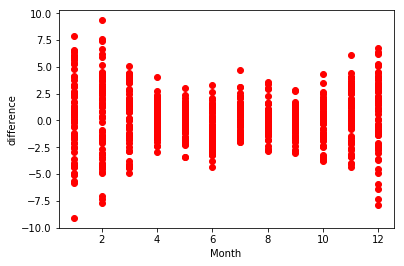

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(plot_df["Month"], plot_df["difference"], "ro")
plt.ylabel('difference')
plt.xlabel('Month')
plt.show()